# DataCamp: Basic about GNNs

https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

In [2]:
!pip install networkx


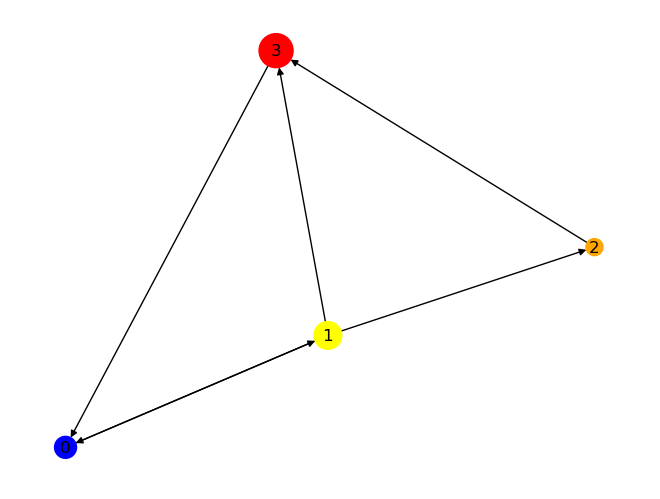

In [3]:
import networkx as nx
H = nx.DiGraph()

#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),
  (1, {"color": "yellow", "size": 400}),
  (2, {"color": "orange", "size": 150}),
  (3, {"color": "red", "size": 600})
])

#adding edges
H.add_edges_from([
  (0, 1),  (1, 2),  (1, 0),  (1, 3),  (2, 3),  (3,0)
])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In [4]:
!pip install -q torch

In [5]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


## Node Classification with GNN

* Updating values in a graph-based structure:
  

$$
X_v^{(l+1)} = W^{(l+1)} \sum_{w \in N(v) \cup \{v\}} \frac{1}{c_{w,v}} X_w^{(l)}
$$

1. **$X_v^{(l+1)}$**: The updated value of $X_v$ at the $(l+1)$-th iteration. $X_v$ represents a feature vector or value associated with node $v$ in the graph.

2. **$W^{(l+1)}$**: A weight matrix applied at the $(l+1)$-th iteration to transform or update the information from the previous iteration.

3. **$\sum_{w \in N(v) \cup \{v\}}$**: The summation runs over all nodes $w$ in the neighborhood of node $v$ (denoted by $N(v)$) as well as node $v$ itself. This aggregates information from $v$ and its neighbors.

4. **$\frac{1}{c_{w,v}}$**: A normalizing factor or weight for the contribution from node $w$ to node $v$, where $c_{w,v}$ could measure the connection strength or some other relationship between nodes $w$ and $v$.

5. **$X_w^{(l)}$**: The value of node $w$ at the $l$-th iteration. It represents the current state or features of node $w$, contributing to the update of node $v$.


Different GNN variants apply different **aggregation functions**, **update rules**, and **normalization techniques**. Here’s how it relates to different types of GNNs:

1. **Graph Convolutional Networks (GCNs)**:
   - Normalization factor $\frac{1}{c_{w,v}}$ (often related to the degree of the nodes).
   - In GCN, this normalization ensures that contributions from neighbors are equally weighted or weighted based on some measure (e.g., node degree).

2. **GraphSAGE**:
   - In **GraphSAGE**, the aggregation function could be mean, LSTM-based, or pooling (max or sum), and neighbors' contributions are aggregated differently (e.g., via concatenation or pooling instead of summing).

3. **Gated Graph Neural Networks (GGNN)**:
   - In GGNNs, message passing is more sophisticated, involving recurrent units (like GRU or LSTM) to propagate information over multiple time steps.

4. **Attention-based GNNs (e.g., GAT)**:
   - **Graph Attention Networks (GAT)** use attention mechanisms to assign different weights to different neighbors dynamically. Instead of a fixed $\frac{1}{c_{w,v}}$, the attention mechanism computes weights based on learned relationships between nodes.

5. **Graph Isomorphism Networks (GIN)**:
   - GINs focus on making the model more expressive by adding more flexibility to the aggregation function (typically a summation followed by a transformation).

### Key differences between GNN variants:
- **Aggregation Function**: Different GNNs use different ways of aggregating neighbors' information (mean, sum, max, LSTM-based, or attention).
- **Weighting Schemes**: Some GNNs use learned or dynamic weights (as in GAT), while others use fixed normalization schemes (as in GCN).
- **Update Rules**: In some GNNs, nodes only update their features using their neighbors’ aggregated features, while others incorporate additional mechanisms like gating (GGNN) or attention (GAT).

In [7]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


## Visualizing Untrained GCN network

Let’s visualize node embeddings of untrained GCN networks using `sklearn.manifold.TSNE` and matplotlib.pyplot. It will plot a 7 dimension node embedding a 2D scatter plot.  

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

We will evaluate the model then add training data to the untrained model to visualize various nodes and categories. 




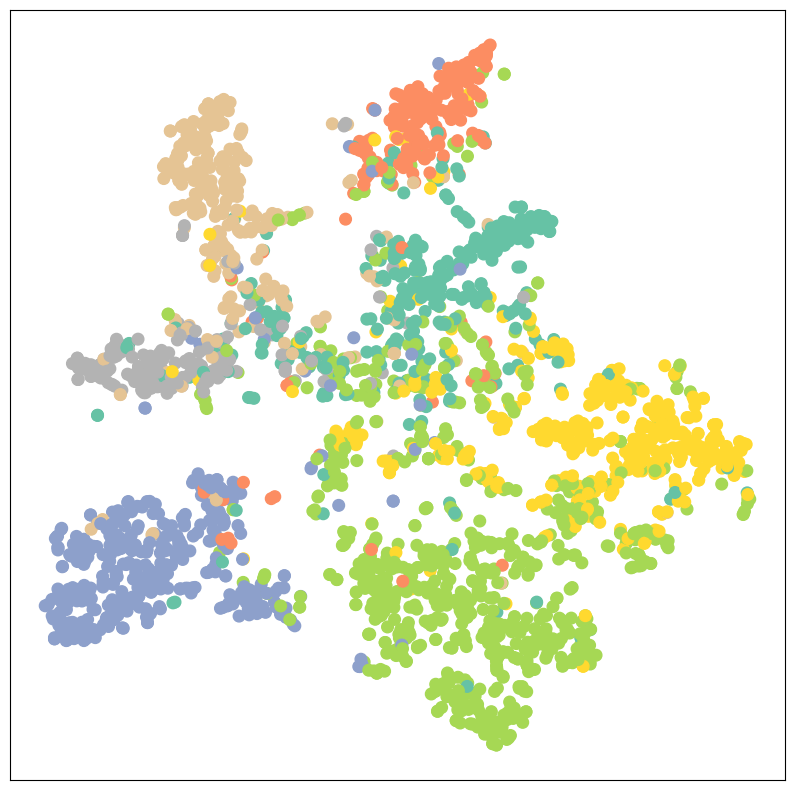

In [17]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Training GNN

We will train our model on 100 Epochs using Adam optimization and the Cross-Entropy Loss function. 

### In the train function, we have:
1. Clear the gradient `optimizer.zero_grad()`
2. Performed a single forward pass. This involves applying the message-passing or aggregation steps over graph layers.
3. Compute loss using training nodes (Cross-Entropy Loss function)
4. Calculate gradient (`loss.backward()`), and update the parameters (`optimizer.step()`)
### In the test function, we have:
1. Predicted node class. After the forward pass, predictions are made for the test nodes. Each node will have a probability distribution across classes.
2. Extracted class label with the highest probability `torch.argmax(prediction, dim=1)`
3. Checked how many values have been predicted correctly
4. Creating accuracy ratio using a sum of correct predictions divided by a total number of nodes. 

In [18]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


## Model Evaluation
We will now evaluate the model on an unseen dataset using the test function, and as you can see, we got pretty good results on `81.5%` accuracy.  

In [19]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8110


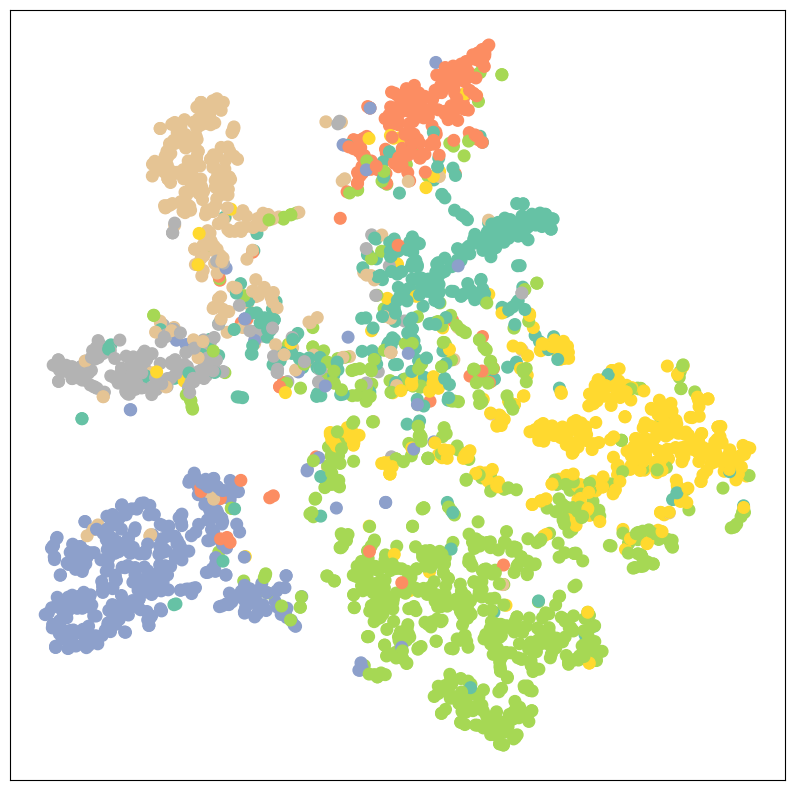

In [20]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Training GATConv Model

In the second, we will replace **GCNConv** with **GATConv** layers. The **Graph Attention Networks** uses *masked self-attentional layers* to address the drawbacks of GCNConv and achieve state-of-the-art results. 

You can also try other GNN layers and play around with optimizations, dropouts, and a number of hidden channels to achieve better performance. 

In the code below, we have just replaced **GCNConv** with **GATConv** with 8 attention heads in the first layer and 1 in the second layer. 

### We will also set:
* dropout rate to 0.6
* hidden channels to 8
* learning rate 0.005

We have modified the test function to find the accuracy of a specific mask (valid, test). It will help us print out validation and test scores during model training. We are also storing validation and test results to a plot line chart later. 

In [21]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1700, Test: 0.2040
Epoch: 002, Loss: 3.9922, Val: 0.2800, Test: 0.3010
Epoch: 003, Loss: 3.9547, Val: 0.3480, Test: 0.3720
Epoch: 004, Loss: 3.9151, Val: 0.3960, Test: 0.4480
Epoch: 005, Loss: 3.8637, Val: 0.4300, Test: 0.4750
Epoch: 006, Loss: 3.8053, Val: 0.4280, Test: 0.4850
Epoch: 007, Loss: 3.7579, Val: 0.4300, Test: 0.4770
Epoch: 008, Loss: 3.6782, Val: 0.4260, Test: 0.4620
Epoch: 009, Loss: 3.5984, Val: 0.4220, Test: 0.4410
Epoch: 010, Loss: 3.5145, Val: 0.4120, Test: 0.4250
Epoch: 011, Loss: 3.4376, Val: 0.3980, Test: 0.4030
Epoch: 012, Loss: 3.3417, Val: 0.3680, Test: 0.3890
Epoch: 013, Loss: 3.2471, Val: 0.3480, Test: 0.3700
Epoch: 014, Loss: 3.1213, Val: 0.3340, Test: 0.3580
Epoch: 015, Loss: 3.0203, Val: 0.3260, Test: 0.3410
Epoch: 016, Loss: 2.9081, Val: 0.3120, Test: 0.3220
Epoch: 017, Loss: 2.7991, Val: 0.2900, Test: 0.3040
Epoch: 018, Loss: 2.6981, Val: 0.2680

As we can observe, our model didn’t perform better than GCNConv. It requires hyperparameter optimization or more Epochs to achieve state-of-the-art results. 

## Model Evaluation
In the evaluation part, we visualize validation and testing scores using matplotlib.pyplot’s line plot.  

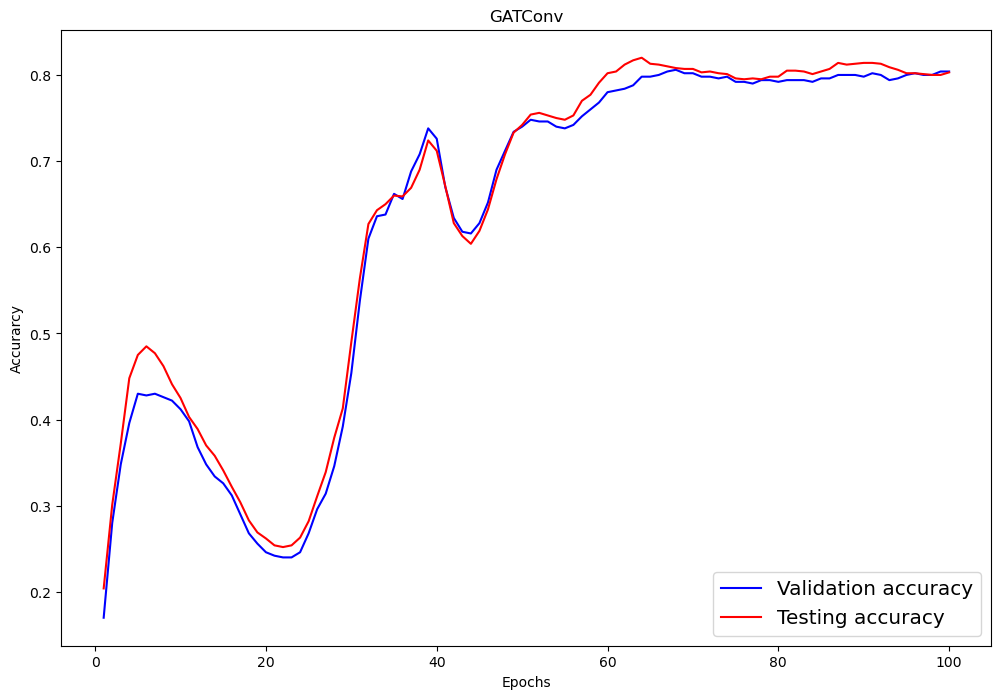

In [22]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

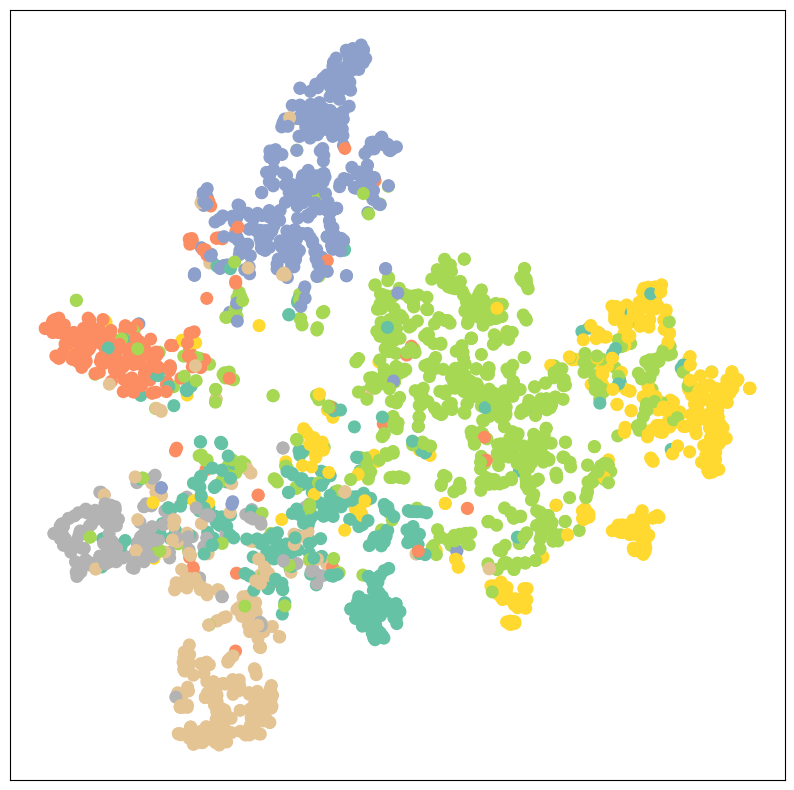

In [23]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)